This is a jupyter nobtebook solving Home Credit prediction problems using Logistic Regression, Random Forest and Gradient Boosting models. 

## Loading packages and data

In [80]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
import warnings
warnings.simplefilter('ignore')

from IPython.display import display, HTML

# from imputer import Imputer
from sklearn.preprocessing import Imputer
from missingpy import KNNImputer
import lightgbm as lgb
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from memory_profiler import profile


In [4]:
path = '../home_credit_data/'

In [5]:
data_train = pd.read_csv(path+'/application_train.csv')

## EDA
First of all, I'm going to deal with the main dataset "application_train.csv".  As most of descriptive staistics and visualization (e. g. distributions of single variables, number of nans, etc.) are presented on [Kaggle](https://www.kaggle.com/c/home-credit-default-risk/data#), I'll use it without reduplicating the same information in this notebook.

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


Firstly, I'd like to see distributions of continious variables in dataset according to their class and find variables that have significant difference between classes and can have a bigger impact inside the model.

LinAlgError: singular matrix

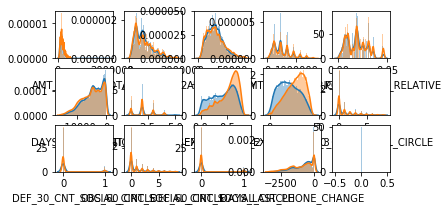

In [10]:
index = 0
for i in data_train.drop(columns='SK_ID_CURR').columns:
    if np.dtype(data_train[i]) == 'float64' and len(data_train[i].dropna())/data_train.shape[0] > 0.6:
        #if sum(data_train[i].dropna() == data_train[i].dropna().astype('int64')):
            index +=1
            plt.subplot(4, 5, index)
            #sns.boxplot(x = data_train.TARGET, y = data_train[i].dropna()[abs(stats.zscore(data_train[i].dropna())) < 3])
            curr_feature_1 = data_train[i][data_train.TARGET == 1].dropna()+ 0.000001
            curr_feature_0 = data_train[i][data_train.TARGET == 0].dropna()- 0.000001
            sns.distplot(curr_feature_1[abs(stats.zscore(curr_feature_1)) < 3]) #to reduce most of outliers
            sns.distplot(curr_feature_0[abs(stats.zscore(curr_feature_0)) < 3])

plt.subplots_adjust(top=3, bottom=0, left=0, right=3, hspace=0.25, wspace=0.55)
plt.show()

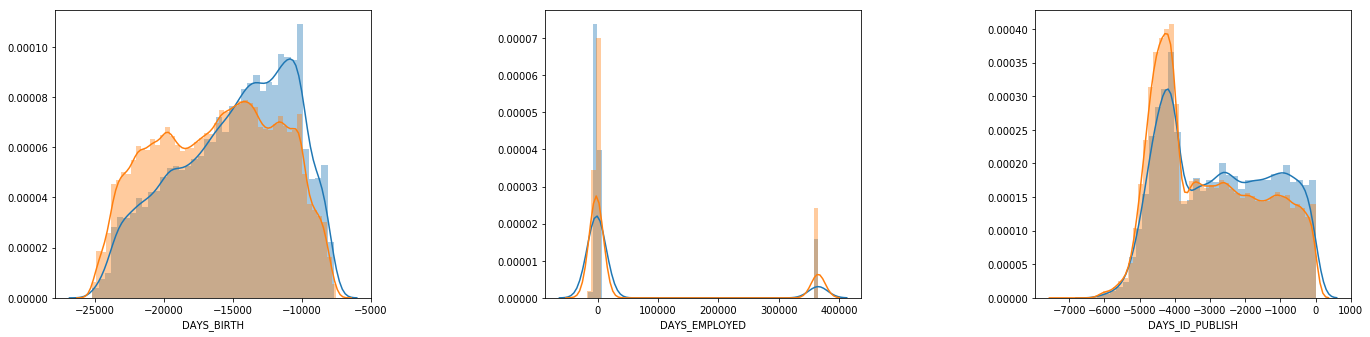

In [11]:
index = 0
for i in data_train.drop(columns=['SK_ID_CURR', 'TARGET']).columns:
    if np.dtype(data_train[i]) == 'int64' and len(data_train[i].dropna())/data_train.shape[0] > 0.6 and len(data_train[i].unique()) > 50:
        index +=1
        plt.subplot(1, 3, index)
        curr_feature_1 = data_train[i][data_train.TARGET == 1].dropna()
        curr_feature_0 = data_train[i][data_train.TARGET == 0].dropna()
        #sns.boxplot(x = data_train.TARGET, y = data_train[i].dropna()[data_train.TARGET == 0])
        #sns.boxplot(x = data_train.TARGET, y = data_train[i].dropna()[data_train.TARGET == 1])
        sns.distplot(curr_feature_1)
        sns.distplot(curr_feature_0)
plt.subplots_adjust(top=1, bottom=0, left=0, right=3, hspace=0.25, wspace=0.55)
plt.show()

Well, according to graphs (taking into account that they are in the interval of 3 sd), some of them are visualised in inappropriate way, except those that are actually continious. So, some of the variables show different distribution between classes like EXT_SOURCE_2(3), DAYS_BIRTH, and probably AMT_INCOME_TOTAL which is quite right-skewed and has outliers, so I need to look a bit closer or apply some transformation. 

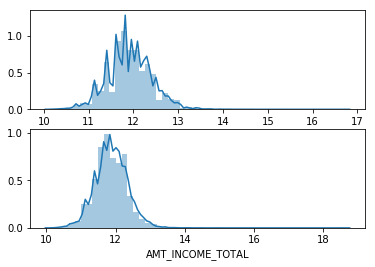

In [12]:
plt.subplot(211)
sns.distplot(np.log(data_train.AMT_INCOME_TOTAL[data_train.TARGET == 0] + 1))
plt.subplot(212)
sns.distplot(np.log(data_train.AMT_INCOME_TOTAL[data_train.TARGET == 1] + 1))
plt.show()

In [13]:
sum(np.log(data_train.AMT_INCOME_TOTAL + 1) > 14) #outliers

158

Now, let's take a look at the varibles of type object,  I'll create crosstables that will show the percentege of TARGET = 1 and TARGET = 0 inside each class of presented variables in order to indicate class or set of them that can be associated with TARGET = 1. However, on the stage of inferential statistics it should be taken into account that there are some very unbalanced classes presented in the tables below.

In [14]:
index = 0
for i in data_train.drop(columns=['SK_ID_CURR', 'TARGET']).columns:
    if np.dtype(data_train[i]) == 'O' and len(data_train[i].dropna())/data_train.shape[0] > 0.6:
        tab = pd.crosstab(data_train.TARGET, data_train[i], margins=True)
        display(HTML((tab/tab.loc[tab.index[-1]]).to_html()))

NAME_CONTRACT_TYPE,Cash loans,Revolving loans,All
TARGET,,,
0,0.916541,0.945217,0.919271
1,0.083459,0.054783,0.080729
All,1.000000,1.000000,1.000000


CODE_GENDER,F,M,XNA,All
TARGET,,,,
0,0.930007,0.898581,1.0,0.919271
1,0.069993,0.101419,0.0,0.080729
All,1.000000,1.000000,1.0,1.000000


FLAG_OWN_CAR,N,Y,All
TARGET,,,
0,0.914998,0.927563,0.919271
1,0.085002,0.072437,0.080729
All,1.000000,1.000000,1.000000


FLAG_OWN_REALTY,N,Y,All
TARGET,,,
0,0.916751,0.920384,0.919271
1,0.083249,0.079616,0.080729
All,1.000000,1.000000,1.000000


NAME_TYPE_SUITE,Children,Family,Group of people,Other_A,Other_B,"Spouse, partner",Unaccompanied,All
TARGET,,,,,,,,
0,0.926232,0.925054,0.915129,0.91224,0.901695,0.921284,0.91817,0.919159
1,0.073768,0.074946,0.084871,0.08776,0.098305,0.078716,0.08183,0.080841
All,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000


NAME_INCOME_TYPE,Businessman,Commercial associate,Maternity leave,Pensioner,State servant,Student,Unemployed,Working,All
TARGET,,,,,,,,,
0,1.0,0.925157,0.6,0.946136,0.94245,1.0,0.636364,0.904115,0.919271
1,0.0,0.074843,0.4,0.053864,0.05755,0.0,0.363636,0.095885,0.080729
All,1.0,1.000000,1.0,1.000000,1.00000,1.0,1.000000,1.000000,1.000000


NAME_EDUCATION_TYPE,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special,All
TARGET,,,,,,
0,0.981707,0.946449,0.91515,0.890723,0.910601,0.919271
1,0.018293,0.053551,0.08485,0.109277,0.089399,0.080729
All,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow,All
TARGET,,,,,,,
0,0.900554,0.924401,0.918058,0.901923,1.0,0.941758,0.919271
1,0.099446,0.075599,0.081942,0.098077,0.0,0.058242,0.080729
All,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000


NAME_HOUSING_TYPE,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents,All
TARGET,,,,,,,
0,0.920677,0.922043,0.914603,0.934276,0.876869,0.883019,0.919271
1,0.079323,0.077957,0.085397,0.065724,0.123131,0.116981,0.080729
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff,All
TARGET,,,,,,,,,,,,,,,,,,,
0,0.951697,0.903933,0.89556,0.93696,0.886739,0.936057,0.938401,0.935361,0.894212,0.828476,0.93786,0.932998,0.934012,0.921438,0.903682,0.929502,0.892576,0.88724,0.912149
1,0.048303,0.096067,0.10444,0.06304,0.113261,0.063943,0.061599,0.064639,0.105788,0.171524,0.06214,0.067002,0.065988,0.078562,0.096318,0.070498,0.107424,0.11276,0.087851
All,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


WEEKDAY_APPR_PROCESS_START,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,All
TARGET,,,,,,,,
0,0.918531,0.922428,0.921127,0.920709,0.918997,0.916495,0.918396,0.919271
1,0.081469,0.077572,0.078873,0.079291,0.081003,0.083505,0.081604,0.080729
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


ORGANIZATION_TYPE,Advertising,Agriculture,Bank,Business Entity Type 1,Business Entity Type 2,Business Entity Type 3,Cleaning,Construction,Culture,Electricity,Emergency,Government,Hotel,Housing,Industry: type 1,Industry: type 10,Industry: type 11,Industry: type 12,Industry: type 13,Industry: type 2,Industry: type 3,Industry: type 4,Industry: type 5,Industry: type 6,Industry: type 7,Industry: type 8,Industry: type 9,Insurance,Kindergarten,Legal Services,Medicine,Military,Mobile,Other,Police,Postal,Realtor,Religion,Restaurant,School,Security,Security Ministries,Self-employed,Services,Telecom,Trade: type 1,Trade: type 2,Trade: type 3,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,XNA,All
TARGET,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.918415,0.895273,0.948145,0.918616,0.914716,0.907004,0.888462,0.883202,0.944591,0.933684,0.928571,0.930219,0.935818,0.920554,0.889317,0.93578,0.913462,0.96206,0.865672,0.927948,0.893838,0.898518,0.931553,0.928571,0.919663,0.875,0.933195,0.943049,0.929651,0.921311,0.934155,0.948747,0.908517,0.923575,0.950021,0.915624,0.893939,0.941176,0.882938,0.940852,0.900216,0.951368,0.898261,0.933968,0.923744,0.91092,0.93,0.896621,0.96875,0.938776,0.954041,0.905504,0.955224,0.92196,0.84246,0.907188,0.951017,0.946004,0.919271
1,0.081585,0.104727,0.051855,0.081384,0.085284,0.092996,0.111538,0.116798,0.055409,0.066316,0.071429,0.069781,0.064182,0.079446,0.110683,0.06422,0.086538,0.03794,0.134328,0.072052,0.106162,0.101482,0.068447,0.071429,0.080337,0.125,0.066805,0.056951,0.070349,0.078689,0.065845,0.051253,0.091483,0.076425,0.049979,0.084376,0.106061,0.058824,0.117062,0.059148,0.099784,0.048632,0.101739,0.066032,0.076256,0.08908,0.07,0.103379,0.03125,0.061224,0.045959,0.094496,0.044776,0.07804,0.15754,0.092812,0.048983,0.053996,0.080729
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000


So, there are some varibles and classes that have a higher percenatge of TARGET = 1. Well, probably it would be better to redefine multinominal features into two classes, for example, "Higher risk" and "Lower risk", what will also allow us not to enlarge the dimensionality with dummy encoding, and then make sure that difference in percentages are statistically significant (e.g. apply chi-square criteria).

The same is with binary features that are presnted below.

In [15]:
index = 0
for i in data_train.drop(columns=['SK_ID_CURR', 'TARGET']).columns:
    if np.dtype(data_train[i]) == 'int64' and len(data_train[i].dropna())/data_train.shape[0] > 0.6 and len(data_train[i].unique()) < 100:
        tab = pd.crosstab(data_train.TARGET, data_train[i], margins=True)
        display(HTML((tab/tab.loc[tab.index[-1]]).to_html()))

CNT_CHILDREN,0,1,2,3,4,5,6,7,8,9,10,11,12,14,19,All
TARGET,,,,,,,,,,,,,,,,
0,0.922882,0.910764,0.912782,0.903686,0.871795,0.916667,0.714286,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.919271
1,0.077118,0.089236,0.087218,0.096314,0.128205,0.083333,0.285714,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.080729
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000


FLAG_MOBIL,0,1,All
TARGET,,,
0,1.0,0.919271,0.919271
1,0.0,0.080729,0.080729
All,1.0,1.000000,1.000000


FLAG_EMP_PHONE,0,1,All
TARGET,,,
0,0.945997,0.9134,0.919271
1,0.054003,0.0866,0.080729
All,1.000000,1.0000,1.000000


FLAG_WORK_PHONE,0,1,All
TARGET,,,
0,0.923149,0.903699,0.919271
1,0.076851,0.096301,0.080729
All,1.000000,1.000000,1.000000


FLAG_CONT_MOBILE,0,1,All
TARGET,,,
0,0.921603,0.919267,0.919271
1,0.078397,0.080733,0.080729
All,1.000000,1.000000,1.000000


FLAG_PHONE,0,1,All
TARGET,,,
0,0.915216,0.929643,0.919271
1,0.084784,0.070357,0.080729
All,1.000000,1.000000,1.000000


FLAG_EMAIL,0,1,All
TARGET,,,
0,0.919154,0.921225,0.919271
1,0.080846,0.078775,0.080729
All,1.000000,1.000000,1.000000


REGION_RATING_CLIENT,1,2,3,All
TARGET,,,,
0,0.951797,0.921109,0.888972,0.919271
1,0.048203,0.078891,0.111028,0.080729
All,1.000000,1.000000,1.000000,1.000000


REGION_RATING_CLIENT_W_CITY,1,2,3,All
TARGET,,,,
0,0.951591,0.920822,0.885978,0.919271
1,0.048409,0.079178,0.114022,0.080729
All,1.000000,1.000000,1.000000,1.000000


HOUR_APPR_PROCESS_START,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
TARGET,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.85,0.918605,0.901639,0.913008,0.917225,0.894173,0.889593,0.899573,0.909235,0.917945,0.919782,0.919256,0.917419,0.919733,0.920923,0.924071,0.925386,0.935101,0.929827,0.931393,0.929766,0.938272,0.9,0.878049,0.919271
1,0.15,0.081395,0.098361,0.086992,0.082775,0.105827,0.110407,0.100427,0.090765,0.082055,0.080218,0.080744,0.082581,0.080267,0.079077,0.075929,0.074614,0.064899,0.070173,0.068607,0.070234,0.061728,0.1,0.121951,0.080729
All,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000


REG_REGION_NOT_LIVE_REGION,0,1,All
TARGET,,,
0,0.91946,0.907022,0.919271
1,0.08054,0.092978,0.080729
All,1.00000,1.000000,1.000000


REG_REGION_NOT_WORK_REGION,0,1,All
TARGET,,,
0,0.919709,0.911094,0.919271
1,0.080291,0.088906,0.080729
All,1.000000,1.000000,1.000000


LIVE_REGION_NOT_WORK_REGION,0,1,All
TARGET,,,
0,0.919429,0.91554,0.919271
1,0.080571,0.08446,0.080729
All,1.000000,1.00000,1.000000


REG_CITY_NOT_LIVE_CITY,0,1,All
TARGET,,,
0,0.922793,0.87774,0.919271
1,0.077207,0.12226,0.080729
All,1.000000,1.00000,1.000000


REG_CITY_NOT_WORK_CITY,0,1,All
TARGET,,,
0,0.926873,0.893886,0.919271
1,0.073127,0.106114,0.080729
All,1.000000,1.000000,1.000000


LIVE_CITY_NOT_WORK_CITY,0,1,All
TARGET,,,
0,0.923415,0.900335,0.919271
1,0.076585,0.099665,0.080729
All,1.000000,1.000000,1.000000


FLAG_DOCUMENT_2,0,1,All
TARGET,,,
0,0.919281,0.692308,0.919271
1,0.080719,0.307692,0.080729
All,1.000000,1.000000,1.000000


FLAG_DOCUMENT_3,0,1,All
TARGET,,,
0,0.938175,0.911551,0.919271
1,0.061825,0.088449,0.080729
All,1.000000,1.000000,1.000000


FLAG_DOCUMENT_4,0,1,All
TARGET,,,
0,0.919265,1.0,0.919271
1,0.080735,0.0,0.080729
All,1.000000,1.0,1.000000


FLAG_DOCUMENT_5,0,1,All
TARGET,,,
0,0.919261,0.919966,0.919271
1,0.080739,0.080034,0.080729
All,1.000000,1.000000,1.000000


FLAG_DOCUMENT_6,0,1,All
TARGET,,,
0,0.91685,0.944346,0.919271
1,0.08315,0.055654,0.080729
All,1.00000,1.000000,1.000000


FLAG_DOCUMENT_7,0,1,All
TARGET,,,
0,0.919265,0.949153,0.919271
1,0.080735,0.050847,0.080729
All,1.000000,1.000000,1.000000


FLAG_DOCUMENT_8,0,1,All
TARGET,,,
0,0.918619,0.92663,0.919271
1,0.081381,0.07337,0.080729
All,1.000000,1.00000,1.000000


FLAG_DOCUMENT_9,0,1,All
TARGET,,,
0,0.919197,0.93823,0.919271
1,0.080803,0.06177,0.080729
All,1.000000,1.00000,1.000000


FLAG_DOCUMENT_10,0,1,All
TARGET,,,
0,0.919269,1.0,0.919271
1,0.080731,0.0,0.080729
All,1.000000,1.0,1.000000


FLAG_DOCUMENT_11,0,1,All
TARGET,,,
0,0.919199,0.937656,0.919271
1,0.080801,0.062344,0.080729
All,1.000000,1.000000,1.000000


FLAG_DOCUMENT_12,0,1,All
TARGET,,,
0,0.919271,1.0,0.919271
1,0.080729,0.0,0.080729
All,1.000000,1.0,1.000000


FLAG_DOCUMENT_13,0,1,All
TARGET,,,
0,0.919084,0.972325,0.919271
1,0.080916,0.027675,0.080729
All,1.000000,1.000000,1.000000


FLAG_DOCUMENT_14,0,1,All
TARGET,,,
0,0.919131,0.966777,0.919271
1,0.080869,0.033223,0.080729
All,1.000000,1.000000,1.000000


FLAG_DOCUMENT_15,0,1,All
TARGET,,,
0,0.919209,0.97043,0.919271
1,0.080791,0.02957,0.080729
All,1.000000,1.00000,1.000000


FLAG_DOCUMENT_16,0,1,All
TARGET,,,
0,0.918954,0.950868,0.919271
1,0.081046,0.049132,0.080729
All,1.000000,1.000000,1.000000


FLAG_DOCUMENT_17,0,1,All
TARGET,,,
0,0.919256,0.97561,0.919271
1,0.080744,0.02439,0.080729
All,1.000000,1.00000,1.000000


FLAG_DOCUMENT_18,0,1,All
TARGET,,,
0,0.919075,0.9432,0.919271
1,0.080925,0.0568,0.080729
All,1.000000,1.0000,1.000000


FLAG_DOCUMENT_19,0,1,All
TARGET,,,
0,0.919262,0.934426,0.919271
1,0.080738,0.065574,0.080729
All,1.000000,1.000000,1.000000


FLAG_DOCUMENT_20,0,1,All
TARGET,,,
0,0.919273,0.916667,0.919271
1,0.080727,0.083333,0.080729
All,1.000000,1.000000,1.000000


FLAG_DOCUMENT_21,0,1,All
TARGET,,,
0,0.91929,0.864078,0.919271
1,0.08071,0.135922,0.080729
All,1.00000,1.000000,1.000000


## Hypotheses testing

In this block, I'll perform chi-square test for those variables that seem to have a significant association with TARGET.

In [16]:
def chi_test(data, feature, target = 'TARGET', group_classes=False):
    
    if sum(pd.isna(data[feature])):
        data[feature].replace(np.nan, 'Unknown', inplace=True)

    cnt_table = pd.crosstab(data[target], data[feature])#to check if there are enough observations in each class
    
    if group_classes:
        tab = pd.crosstab(data[target], data[feature], margins=True)
        tab = tab/tab.loc[tab.index[-1]]
        labels = {}
        for i in cnt_table.columns:
            if tab[i][1] > tab['All'][1]:
                labels[i] = 'High risk'
            else:
                labels[i] = 'Low risk'
        cnt_bi_table = pd.crosstab(data[target], data[feature].replace(labels))
        chi = stats.chi2_contingency(cnt_bi_table)
        display(HTML(pd.crosstab(data[target], data[feature].replace(labels), margins=True).to_html()))
        print( { 'Chi-square statisitc': chi[0],
           'p-value': chi[1], 
          'df': chi[2]} )
        return labels
    else:
        chi = stats.chi2_contingency(cnt_table)                           
        display(HTML(pd.crosstab(data[target], data[feature], margins=True).to_html()))
        print( { 'Chi-square statisitc': chi[0],
           'p-value': chi[1], 
          'df': chi[2]} )

In [17]:
chi_test(data_train[data_train.CODE_GENDER != 'XNA'], 'CODE_GENDER')

CODE_GENDER,F,M,All
TARGET,,,
0,188278,94404,282682
1,14170,10655,24825
All,202448,105059,307507


{'Chi-square statisitc': 920.0057254249849, 'p-value': 4.394091339983112e-202, 'df': 1}


In [18]:
inc_labels = chi_test(data_train, 'NAME_INCOME_TYPE', group_classes=True)

NAME_INCOME_TYPE,High risk,Low risk,All
TARGET,,,
0,143567,139119,282686
1,15234,9591,24825
All,158801,148710,307511


{'Chi-square statisitc': 1022.2458887086157, 'p-value': 2.62339845557261e-224, 'df': 1}


So, here we see that while the groups High risk and Low risk have almost the same number of observatoins (158801 and 148710) the class TARGET=1 is almost 60% frequent than TARGET=0, therefore probably such division can be informative in model. The same can be done with the next feature NAME_EDUCATION_TYPE, but as far as this feature is ordinal, I think it'd better to put them in right order while encoding. 

In [19]:
hsng_labels = chi_test(data_train, 'NAME_HOUSING_TYPE', group_classes=True)

NAME_HOUSING_TYPE,High risk,Low risk,All
TARGET,,,
0,27612,255074,282686
1,3292,21533,24825
All,30904,276607,307511


{'Chi-square statisitc': 307.64709917361216, 'p-value': 7.108770671170459e-69, 'df': 1}


Well, although p-value is significant, the difference in TARGET = 1 between groups is about 3%, therefore I don't think that this feature should be present in model with such division.

In [20]:
occup_labels = chi_test(data_train, 'OCCUPATION_TYPE', group_classes=True)

OCCUPATION_TYPE,High risk,Low risk,All
TARGET,,,
0,113314,169372,282686
1,13338,11487,24825
All,126652,180859,307511


{'Chi-square statisitc': 1753.0884810292614, 'p-value': 0.0, 'df': 1}


Here we see the difference in about 4%, not much, but still it can be included in the model in such division, because it has too many classes.

In [21]:
orgn_labels = chi_test(data_train, 'ORGANIZATION_TYPE', group_classes=True)

ORGANIZATION_TYPE,High risk,Low risk,All
TARGET,,,
0,150847,131839,282686
1,16131,8694,24825
All,166978,140533,307511


{'Chi-square statisitc': 1240.5868105813465, 'p-value': 9.220915322133472e-272, 'df': 1}


In this feature there is also a significant difference in numbers between High risk TARGET=1 and Low risk TARGET = 1, moreover such grouping in this feature again reduces quite a big number of classes (58).

## Data preprocessing

### Dealing with NA

The are quite a lot of features that have too many missing values. Let's see what can be done about it. The first feature OWN_CAR_AGE has for about 66% values missing.  As there is also FLAG_OWN_CAR feature that represents if client have a car, we will see if nans can be explained by absence of the car.

In [22]:
data_train.shape

(307511, 122)

In [23]:
print( sum(data_train.FLAG_OWN_CAR == "Y") )
print( data_train.OWN_CAR_AGE.dropna().shape )

104587
(104582,)


Well, obviously nans are produced by absence of the car, then we can just impute 0 instead of nans. 

In [24]:
data_train.OWN_CAR_AGE.fillna(value = 0, inplace=True)

The next feature is OCCUPATION_TYPE and we don't know the origin of nans. I suppose that it can be two things: client refused telling it or he doesn't have a job, but still both of these tells us some information about client, therefore I will replace nans by 'Unknown'.  After cleaning data from missing values I'll encode this feature.

In [ ]:
print( data_train.OCCUPATION_TYPE.unique() )
data_train.OCCUPATION_TYPE.fillna(value = 'Unknown', inplace=True)

Next subset of features is about means of communications provided by client. There are very imbalanced classes inside each feature, so it should be taken into account during train-test split. Moreover some features are presented by only one class that significantly prevail and some of them can be dropped.

In [26]:
print( sum(data_train.FLAG_MOBIL == 0) )
print( sum(data_train.FLAG_MOBIL == 1) )

1
307510


In [27]:
print( sum(data_train.FLAG_CONT_MOBILE == 0) )
print( sum(data_train.FLAG_CONT_MOBILE == 1) )

574
306937


In [28]:
data_train.drop(columns=['FLAG_MOBIL', 'FLAG_CONT_MOBILE'], inplace=True)

Another subset of features is about provided documents and almost all of them have an enormous dominance by one class, so I think it would make sense to combine them to feature which will represent the number of provided documents.

In [29]:
data_train.shape

(307511, 120)

In [30]:
data_train['DOC_COUNT'] = data_train.FLAG_DOCUMENT_2

for i in range(3, 22):
    data_train['DOC_COUNT'] = data_train['DOC_COUNT'] + data_train['FLAG_DOCUMENT_'+str(i)]

The next subset (second plot below) of features has too many nans (>50%) and it would be better to see how these nans distributed in our data. 

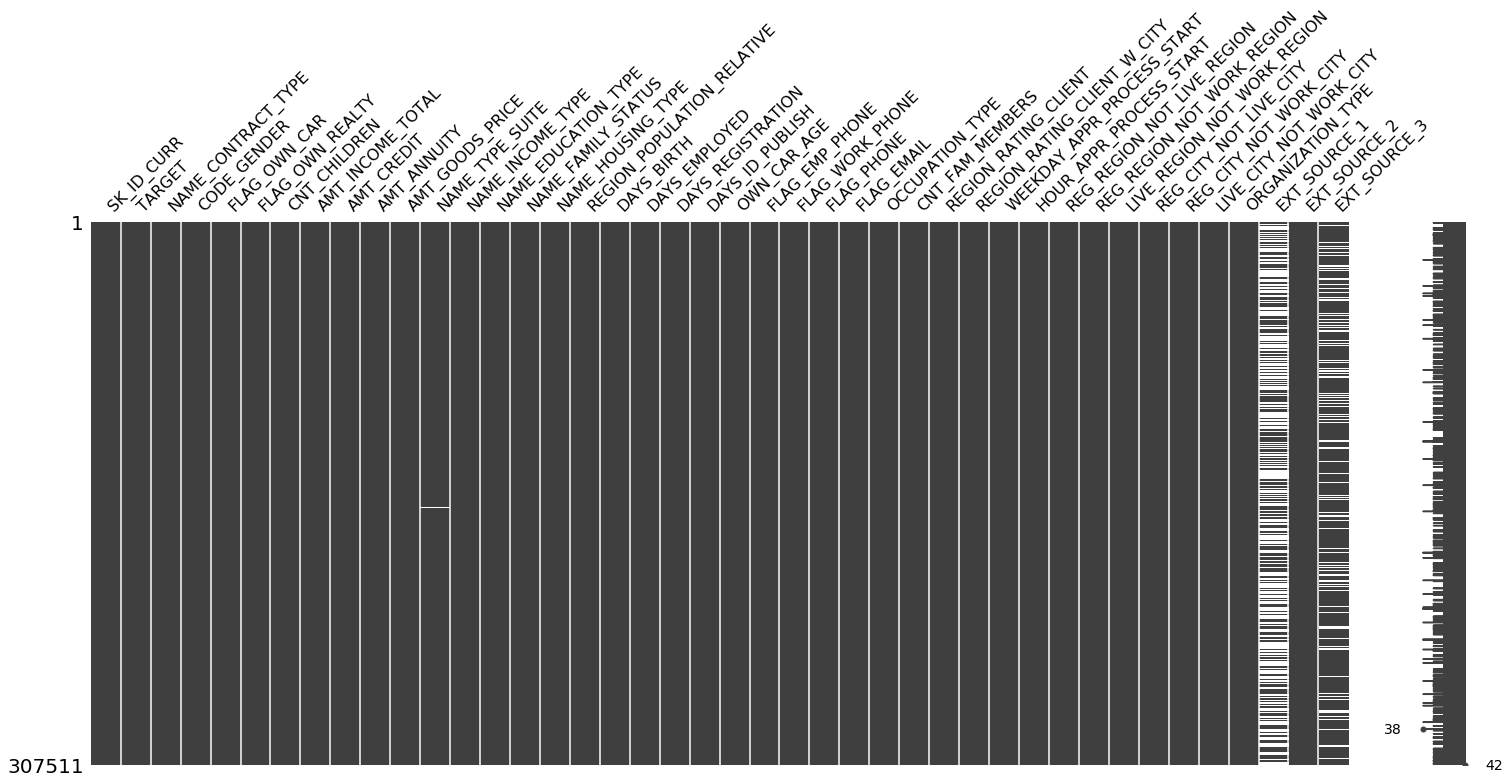

In [31]:
msno.matrix(data_train.iloc[:,0:42])
plt.show()

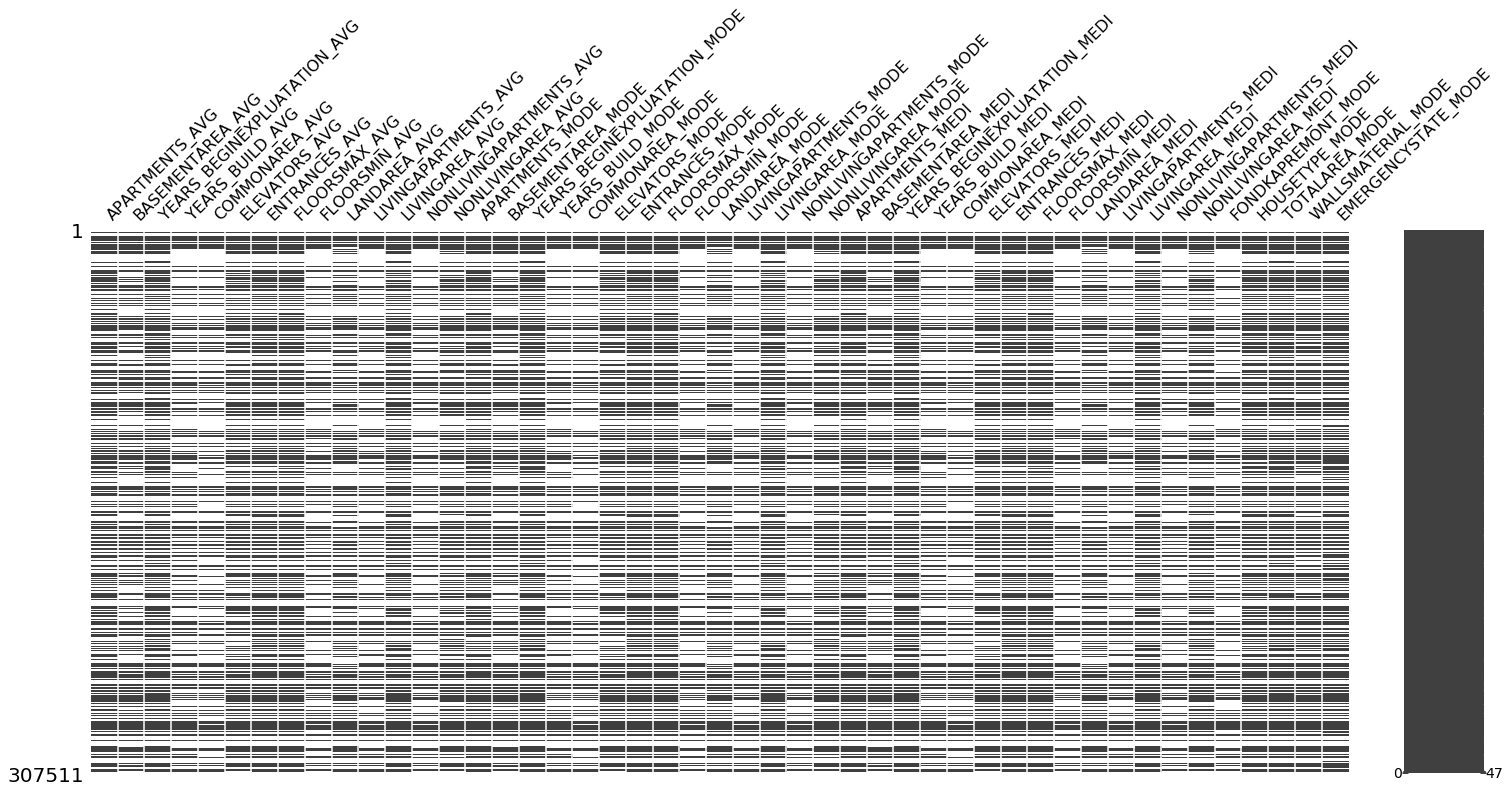

In [32]:
msno.matrix(data_train.iloc[:,42:89])
plt.show()

In [ ]:
msno.matrix(data_train.iloc[:,89:])
plt.show()

Well, we see that almost all features from the second plot have too many missings. All these features are connected with the information about apartments. As it would be inaccurate to use features with such number of missings, probably it would be better to create one feature from them, that would represent the percentage of known information about client's apartments.

In [34]:
for i in data_train.iloc[:, 42:56].columns:
    data_train[i] = -pd.isna(data_train[i])

for i in data_train.iloc[:, 84:89].columns:
    data_train[i] = -pd.isna(data_train[i])

In [35]:
data_train['HOUSE_INFO'] = (data_train.iloc[:, 84:89].sum(axis=1) + data_train.iloc[:, 42:56].sum(axis=1))/19

The last five columns shows the number of enquiries to Credit Bureau and number of enquiries of each next column excludes those that were already marked in previous one. Nans make up 14% in each column. I'll fill them later.

In [36]:
#for i in data_train.iloc[:, 114:120].columns:
#   data_train[i].fillna(data_train[i].median(), inplace = True)

Now dropping all columns that have (>=50%) of values missing and those that was combined into one (DOC_COUNT).

In [37]:
data_train.drop(columns=data_train.iloc[:, 94:114].columns, inplace=True)
data_train.drop(columns=data_train.iloc[:, 42:89].columns, inplace=True)
data_train.drop(columns='EXT_SOURCE_1', inplace=True)

The last column with a significant number of gaps is EXT_SOURCE_3, that has 16% of values missing, therefore I must find an appropriate way to fill them.

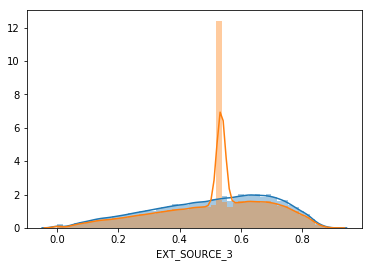

In [38]:
sns.distplot(data_train.EXT_SOURCE_3.dropna())
sns.distplot(data_train.EXT_SOURCE_3.fillna(data_train.EXT_SOURCE_3.dropna().median()))
plt.show()

Well, as for me, imputations that made using mean/median are not suitable in that case because they violate the distribution. Probably, it would be better to use another strategy, for example, KNN to fill these gaps taking into account what values have nearest objects in a multidimensional space, but firstly, it's better to encode categorical features in order to perform imputation function faster. 

In [39]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 54 columns):
SK_ID_CURR                     307511 non-null int64
TARGET                         307511 non-null int64
NAME_CONTRACT_TYPE             307511 non-null object
CODE_GENDER                    307511 non-null object
FLAG_OWN_CAR                   307511 non-null object
FLAG_OWN_REALTY                307511 non-null object
CNT_CHILDREN                   307511 non-null int64
AMT_INCOME_TOTAL               307511 non-null float64
AMT_CREDIT                     307511 non-null float64
AMT_ANNUITY                    307499 non-null float64
AMT_GOODS_PRICE                307233 non-null float64
NAME_TYPE_SUITE                306219 non-null object
NAME_INCOME_TYPE               307511 non-null object
NAME_EDUCATION_TYPE            307511 non-null object
NAME_FAMILY_STATUS             307511 non-null object
NAME_HOUSING_TYPE              307511 non-null object
REGION_POPULATION_RELATI

In [40]:
to_be_scaled = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH']
for i in data_train.columns:
    if data_train[i].dtype == 'float64':
        to_be_scaled.append(i)

In [41]:
data_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOC_COUNT,HOUSE_INFO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


### Encoding

In [42]:
for i in data_train.columns:
    if data_train[i].dtype == 'O':
        print( [i, data_train[i].unique()] )

['NAME_CONTRACT_TYPE', array(['Cash loans', 'Revolving loans'], dtype=object)]
['CODE_GENDER', array(['M', 'F', 'XNA'], dtype=object)]
['FLAG_OWN_CAR', array(['N', 'Y'], dtype=object)]
['FLAG_OWN_REALTY', array(['Y', 'N'], dtype=object)]
['NAME_TYPE_SUITE', array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', nan, 'Other_B', 'Group of people'], dtype=object)]
['NAME_INCOME_TYPE', array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)]
['NAME_EDUCATION_TYPE', array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)]
['NAME_FAMILY_STATUS', array(['Single / not married', 'Married', 'Civil marriage', 'Widow',
       'Separated', 'Unknown'], dtype=object)]
['NAME_HOUSING_TYPE', array(['House / apartment', 'Rented apartment', 'With parents',
       'Municipal apartment', 

In [43]:
sum(data_train.CODE_GENDER == 'XNA')

4

In [44]:
data_train.CODE_GENDER.replace('XNA', 'F', inplace=True)
data_train.NAME_INCOME_TYPE.replace(inc_labels, inplace=True)
data_train.OCCUPATION_TYPE.replace(occup_labels, inplace=True)
data_train.ORGANIZATION_TYPE.replace(orgn_labels, inplace=True)
data_train.WEEKDAY_APPR_PROCESS_START.replace({'WEDNESDAY': 'Week', 'MONDAY': 'Week', 'THURSDAY': 'Week', 'SUNDAY': 'Weekend',
                                               'SATURDAY': 'Weekend', 'FRIDAY': 'Week', 'TUESDAY': 'Week'}, inplace=True)

In [45]:
data_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOC_COUNT,HOUSE_INFO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


In [46]:
binarizer = LabelBinarizer()

In [47]:
for i in data_train.columns:
    if data_train[i].dtype == 'O' and len(data_train[i].unique()) == 2:
        data_train[i] = binarizer.fit_transform(data_train[i])

In [48]:
data_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOC_COUNT,HOUSE_INFO
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


In [49]:
encoder = LabelEncoder()

In [50]:
sum(data_train.NAME_TYPE_SUITE.isnull())

1292

In [51]:
data_train.NAME_TYPE_SUITE = encoder.fit_transform(data_train.NAME_TYPE_SUITE.replace(np.nan, 'Unknown'))

In [52]:
print( encoder.classes_ )
sum(data_train.NAME_TYPE_SUITE == 7)

['Children' 'Family' 'Group of people' 'Other_A' 'Other_B'
 'Spouse, partner' 'Unaccompanied' 'Unknown']


1292

In [53]:
data_train.NAME_TYPE_SUITE.replace('Unknown', np.nan, inplace=True)

In [54]:
data_train.NAME_EDUCATION_TYPE = encoder.fit_transform(data_train.NAME_EDUCATION_TYPE)

In [55]:
encoder.classes_ #ordered

array(['Academic degree', 'Higher education', 'Incomplete higher',
       'Lower secondary', 'Secondary / secondary special'], dtype=object)

In [56]:
data_train = pd.get_dummies(data_train)

In [57]:
data_train.shape

(307511, 64)

### Imputation

In [61]:
impute = KNNImputer()

In [81]:
%%time
data_train_cl = pd.DataFrame(impute.fit_transform(X=data_train, column='EXT_SOURCE_3', k = 3), columns=data_train.columns)

MemoryError: 

In [ ]:
sns.distplot(data_train.EXT_SOURCE_3.dropna())
sns.distplot(data_train_cl.EXT_SOURCE_3)
plt.show()

In [ ]:
%%time
for i in data_train.columns:
    if sum(data_train[i].isnull()):
        data_train_cl = pd.DataFrame(impute.knn(X=data_train_cl, column=i, k = 3), columns=data_train.columns)

In [ ]:
data_train_cl.head()

### Standardization

In [ ]:
std = RobustScaler()
for i in to_be_scaled:
    data_train_cl[i] = std.fit_transform(pd.DataFrame(data_train_cl[i], columns=[i]))

## Model Building

### Logistic regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_train_cl.drop(columns='TARGET'), 
                                                    data_train_cl.TARGET, test_size=0.2, random_state=23, stratify=data_train_cl.TARGET)

In [ ]:
%%time
results = {}
for i in [0.001, 0.01, 0.1, 1, 2]:
    lgreg = LogisticRegression(C=i, class_weight='balanced', penalty='l2', max_iter=1000)
    lgreg.fit(X=X_train, y=y_train)
    pred = lgreg.predict(X_test)
    results[i] = roc_auc_score(y_test, pred)

In [ ]:
results

### Random Forest

In [ ]:
forest = RandomForestClassifier(max_depth=10, n_estimators=200, class_weight='balanced', n_jobs=-1)

In [ ]:
%%time
forest.fit(X_train, y_train)

In [ ]:
pred2 = forest.predict(X_test)

In [ ]:
roc_auc_score(y_test, pred2)

### Gradient boosting

In [ ]:
# for validation lgb
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_train, 
                                                    y_train, test_size=0.2, random_state=23)

In [ ]:
train_data = lgb.Dataset(X_train_v, label=y_train_v)
test_data = lgb.Dataset(X_test_v, label=y_test_v)

In [ ]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 30,
    'learning_rate': 0.05,
    'verbose': 0
}


In [ ]:
model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

Testing on left-off set

In [ ]:
pred4= model.predict(X_test)

In [ ]:
roc_auc_score(y_test, pred4)